In [118]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.layers import MultiHeadAttention
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
from keras.optimizers import RMSprop, Nadam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.callbacks import LearningRateScheduler
import math

from cordex_discrete import cordex_discrete
from cordex_continuous import cordex_continuous
from plot_fun import subplot_results
from Jcb import calc_basis_matrix, Jcb

In [114]:
# def create_autoencoder(input_dim, latent_dim):
#     # Calculate the number of layers for the encoder and decoder based on the input dimension
#     num_layers = int(np.log2(input_dim / latent_dim))
#
#     # Create the input layer
#     input_layer = Input(shape=(input_dim,))
#
#     # Build the encoder layers
#     encoder = input_layer
#     for i in range(num_layers):
#         n_neurons = int(input_dim / (2 ** (i + 1)))
#         encoder = Dense(n_neurons, activation='relu')(encoder)
#
#     # Latent space layer
#     latent_space = Dense(latent_dim, activation='tanh', name='latent_space')(encoder)
#
#     # Build the decoder layers
#     decoder = latent_space
#     for i in range(num_layers, 0, -1):
#         n_neurons = int(input_dim / (2 ** i))
#         decoder = Dense(n_neurons, activation='relu')(decoder)
#
#     # Output layer
#     decoder_output = Dense(input_dim, activation='tanh')(decoder)
#
#     # Create the autoencoder, encoder, and decoder models
#     autoencoder = Model(inputs=input_layer, outputs=decoder_output)
#     encoder = Model(inputs=input_layer, outputs=latent_space)
#
#     encoded_input = Input(shape=(latent_dim,))
#     decoded_output = encoded_input
#     decoder_layers = autoencoder.layers[-(num_layers+1):]
#     for layer in decoder_layers:
#         decoded_output = layer(decoded_output)
#     decoder = Model(inputs=encoded_input, outputs=decoded_output)
#
#     return autoencoder, encoder, decoder

In [135]:
def create_autoencoder(input_dim, latent_dim, dropout_rate=0.1):
    # Calculate the number of layers for the encoder and decoder based on the input dimension
    num_layers = int(np.log2(input_dim / latent_dim))

    # Create the input layer
    input_layer = Input(shape=(input_dim,))

    # Build the encoder layers
    encoder = input_layer
    for i in range(num_layers):
        n_neurons = int(input_dim / (2 ** (i + 1)))
        encoder = Dense(n_neurons, activation='relu')(encoder)
        encoder = Dropout(dropout_rate)(encoder)

    # Latent space layer
    latent_space = Dense(latent_dim, activation='tanh', name='latent_space')(encoder)

    # Build the decoder layers
    decoder = latent_space
    for i in range(num_layers, 0, -1):
        n_neurons = int(input_dim / (2 ** i))
        decoder = Dense(n_neurons, activation='relu')(decoder)
        decoder = Dropout(dropout_rate)(decoder)

    # Output layer
    decoder_output = Dense(input_dim, activation='tanh')(decoder)

    # Create the autoencoder, encoder, and decoder models
    autoencoder = Model(inputs=input_layer, outputs=decoder_output)
    encoder = Model(inputs=input_layer, outputs=latent_space)

    encoded_input = Input(shape=(latent_dim,))
    decoded_output = encoded_input
    decoder_layers = autoencoder.layers[-(num_layers*2+1):]
    for layer in decoder_layers:
        decoded_output = layer(decoded_output)
    decoder = Model(inputs=encoded_input, outputs=decoded_output)

    return autoencoder, encoder, decoder

# Define a step decay function
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def exponential_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate * np.exp(-k * epoch)
    return lrate

def inverse_decay(epoch):
    initial_lrate = 0.001
    k = 0.1
    lrate = initial_lrate / (1 + k * epoch)
    return lrate

def cosine_annealing(epoch, T_max=50, eta_min=0.0001):
    initial_lrate = 0.001
    lrate = eta_min + 0.5 * (initial_lrate - eta_min) * (1 + np.cos(np.pi * epoch / T_max))
    return lrate

In [303]:
runs = 4
levels = np.linspace(-1,1,3).tolist()
optimality = 'A'
n_x = [100]
n_b = [2]
scalars = 0
J_cb = Jcb(*[calc_basis_matrix(x_basis=x, b_basis=b) for x, b in zip(n_x, n_b)])

In [304]:
# Generate design matrices using cordex_descrite
num_designs = 1_000
design_matrices = []
criteria_matrix = []
for _ in tqdm(range(num_designs)):
    opt_design, opt_cr = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=1, optimality=optimality, J_cb=J_cb, disable_bar=True)
    # opt_design, opt_cr = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, epochs=1, final_pass=False, main_bar=False)
    design_matrices.extend(opt_design)
    criteria_matrix.append(opt_cr)


design_matrices = np.array(design_matrices)

scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_designs = scaler.fit_transform(design_matrices.reshape(num_designs, -1))

# Split the data into training and validation sets
train_data, val_data = train_test_split(normalized_designs, test_size=0.2, random_state=42)

100%|██████████| 1000/1000 [01:14<00:00, 13.36it/s]


In [259]:
# Define autoencoder architecture
input_dim = normalized_designs.shape[1]
latent_dim = runs

autoencoder, encoder, decoder = create_autoencoder(input_dim, latent_dim, dropout_rate=0.01)

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=RMSprop(), loss=tf.keras.losses.Huber())
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = autoencoder.fit(train_data, train_data,
                          epochs=1000,
                          batch_size=32,
                          validation_data=(val_data, val_data),
                          callbacks=[early_stopping])

Epoch 1/1000
250/250 [==============================] - 2s 2ms/step - loss: 0.4168 - val_loss: 0.3702
Epoch 2/1000
250/250 [==============================] - 0s 649us/step - loss: 0.3564 - val_loss: 0.3143
Epoch 3/1000
250/250 [==============================] - 0s 639us/step - loss: 0.3031 - val_loss: 0.2590
Epoch 4/1000
250/250 [==============================] - 0s 648us/step - loss: 0.2666 - val_loss: 0.2360
Epoch 5/1000
250/250 [==============================] - 0s 655us/step - loss: 0.2512 - val_loss: 0.2265
Epoch 6/1000
250/250 [==============================] - 0s 631us/step - loss: 0.2425 - val_loss: 0.2153
Epoch 7/1000
250/250 [==============================] - 0s 616us/step - loss: 0.2357 - val_loss: 0.2087
Epoch 8/1000
250/250 [==============================] - 0s 621us/step - loss: 0.2337 - val_loss: 0.2058
Epoch 9/1000
250/250 [==============================] - 0s 648us/step - loss: 0.2297 - val_loss: 0.2019
Epoch 10/1000
250/250 [==============================] - 0s 659us/

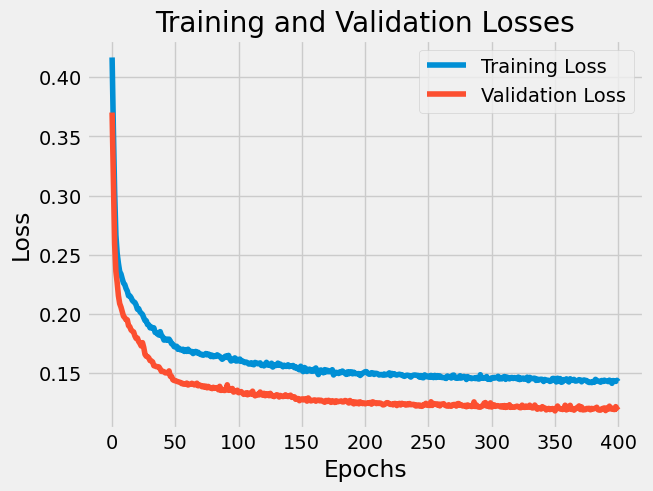

In [260]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

### Denoising Autoencoder Example

In [261]:
noise_factor = 0.1  # Adjust this value based on the desired noise level

# Add noise to the design matrices
noisy_designs = normalized_designs + noise_factor * np.random.normal(size=normalized_designs.shape)
noisy_designs = np.clip(noisy_designs, -1, 1)
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(noisy_designs, normalized_designs, test_size=0.2, random_state=42)

In [262]:
# Define autoencoder architecture
input_dim = normalized_designs.shape[1]
latent_dim = 4

autoencoder, encoder, decoder = create_autoencoder(input_dim, latent_dim, dropout_rate=0.01)

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=RMSprop(), loss=tf.keras.losses.Huber())
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history = autoencoder.fit(x_train, y_train,
                          epochs=5000,
                          batch_size=32,
                          validation_data=(x_val, y_val),
                          callbacks=[early_stopping])

Epoch 1/5000
250/250 [==============================] - 1s 2ms/step - loss: 0.4037 - val_loss: 0.3121
Epoch 2/5000
250/250 [==============================] - 0s 858us/step - loss: 0.3069 - val_loss: 0.2814
Epoch 3/5000
250/250 [==============================] - 0s 881us/step - loss: 0.2909 - val_loss: 0.2686
Epoch 4/5000
250/250 [==============================] - 0s 669us/step - loss: 0.2785 - val_loss: 0.2501
Epoch 5/5000
250/250 [==============================] - 0s 649us/step - loss: 0.2611 - val_loss: 0.2341
Epoch 6/5000
250/250 [==============================] - 0s 1ms/step - loss: 0.2508 - val_loss: 0.2253
Epoch 7/5000
250/250 [==============================] - 0s 815us/step - loss: 0.2422 - val_loss: 0.2129
Epoch 8/5000
250/250 [==============================] - 0s 756us/step - loss: 0.2333 - val_loss: 0.2044
Epoch 9/5000
250/250 [==============================] - 0s 676us/step - loss: 0.2271 - val_loss: 0.2003
Epoch 10/5000
250/250 [==============================] - 0s 682us/st

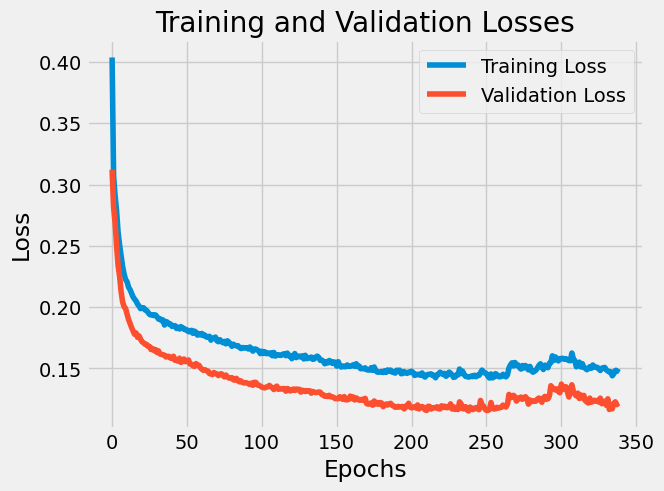

In [263]:
# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [86]:
opt_design, opt_cr = cordex_continuous(runs=runs, f_list=n_x, scalars=0, optimality=optimality, J_cb=J_cb, epochs=1000, final_pass=True, main_bar=True)
opt_cr

  0%|          | 4/1000 [00:04<16:51,  1.02s/it]


KeyboardInterrupt: 

In [150]:
example_design, _ = cordex_discrete(runs=runs, f_list=n_x, scalars=scalars, levels=[-1, 1], epochs=1, optimality=optimality, J_cb=J_cb, disable_bar=True)
x = scaler.transform(example_design.reshape(1, -1))
latent_representation = encoder.predict(x)
decoded_output = decoder.predict(latent_representation).reshape(-1, sum(n_x))

1/1 [==============================] - 0s 19ms/step


In [151]:
print(latent_representation)

[[-0.99992853 -0.99999976  0.9517939   0.8349516 ]]


In [152]:
# Compute the reconstruction error (e.g., mean squared error)
reconstruction_error = np.mean((example_design - decoded_output) ** 2)
print("\nReconstruction error (MSE):", np.round(reconstruction_error,4))


Reconstruction error (MSE): 0.2703


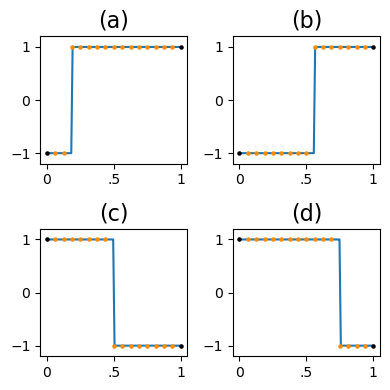

In [153]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=example_design, style='default', size=5)

In [154]:
objective_function(example_design, runs, sum(n_x), J_cb=J_cb)

9.48250220394948

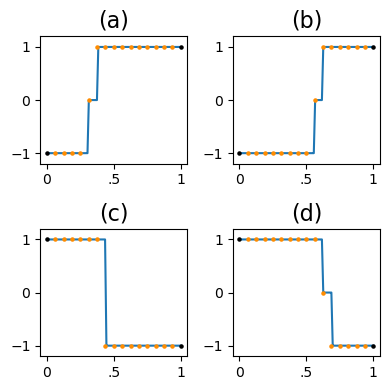

In [155]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=np.round(decoded_output), style='default', size=5)

In [156]:
objective_function(np.round(decoded_output), runs, sum(n_x), J_cb=J_cb)

10.309185560951821

In [172]:
def objective_function(X, m, n, J_cb=None, noise=0.1):
    ones = np.ones((m, 1)).reshape(-1,1)
    X = np.array(X).reshape(m, n)
    Z = np.hstack((ones, X @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M) + np.random.normal(0, noise)

In [51]:
objective_function(example_design, runs, sum(n_x), J_cb=J_cb)

NameError: name 'example_design' is not defined

In [52]:
objective_function(np.round(decoded_output), runs, sum(n_x), J_cb=J_cb)

NameError: name 'decoded_output' is not defined

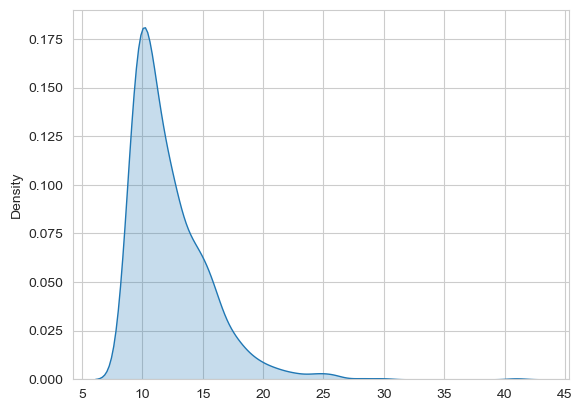

In [11]:
# plot the distribution of criteria_matrix with kde density with matplotlib
import seaborn as sns
sns.kdeplot(criteria_matrix, fill=True)
plt.show()

In [14]:
reconstructed_criterion = []
for design in design_matrices.reshape(1000, runs, sum(n_x)):
    normalized_example = scaler.transform(design.reshape(1, -1))

    # Encode and decode the example design
    encoded_example = encoder.predict(normalized_example)
    decoded_example = decoder.predict(encoded_example)

    # Inverse transform the decoded example to get the reconstructed design
    reconstructed_example = scaler.inverse_transform(decoded_example).reshape(normalized_example.shape)
    reconstructed_criterion.append(objective_function(reconstructed_example, runs, sum(n_x), J_cb=J_cb))

1/1 [==============================] - 0s 16ms/step


2023-04-15 01:28:33.414513: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 9ms/step


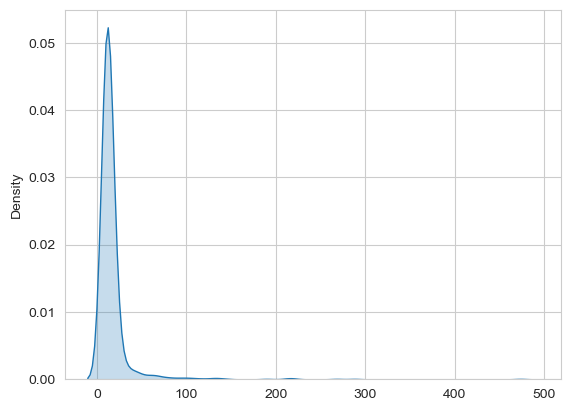

In [15]:
sns.kdeplot(reconstructed_criterion, fill=True)
plt.show()

---

In [37]:
import numpy as np
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor as SkExtraTreesRegressor
from sklearn.base import RegressorMixin
from sklearn.neural_network import MLPRegressor

from skopt.learning.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from skopt.optimizer import Optimizer
from skopt.space import Real, Integer

In [63]:
# Parameters
n_iterations = 200  # Number of iterations for the optimization process
model_update_frequency = 5  # Update the GP model every 5 iterations
random_seed = 42  # Random seed for reproducibility

# Adjust the search space to match the latent space dimension
search_space = [Real(-1., 1.) for _ in range(latent_dim)]

# Create a Gaussian Process (GP) model with a Radial Basis Function (RBF) kernel
kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2))
# kernel = Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, random_state=random_seed)
opt = Optimizer(search_space, base_estimator=gpr, n_initial_points=5, acq_func="LCB", random_state=random_seed)

In [64]:
def damped_oscillation(x, A, b, c, minimum):
    return A * np.exp(-b*x)*(1+np.sin((2*np.pi)/c*x)) + minimum

In [65]:
A = 0.5 # starting position
b = 0.02 # decay rate
c = 10 # period
minimum = 1e-2 # minimum value
for i in tqdm(range(n_iterations)):
    kappa = damped_oscillation(i, A, b, c, minimum)
    opt.acq_func_kwargs = {'kappa': kappa}

    latent_X = opt.ask()
    X_next = decoder.predict(np.array(latent_X).reshape(1, -1), verbose=None)
    X_next = X_next.flatten()
    f_val = objective_function(X_next, runs, sum(n_x), J_cb=J_cb, noise=0.5)
    opt.tell(latent_X, f_val)

100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


In [66]:
# Convert yi list to NumPy array
yi_array = np.array(opt.yi)
positive_yi_indices = np.where(yi_array > 0)
min_positive_yi_index = positive_yi_indices[0][np.argmin(yi_array[positive_yi_indices])]
optimal_latent_X = opt.Xi[min_positive_yi_index]

# Decode the optimal point in the latent space back into the design matrix space
optimal_X = decoder.predict(np.array(optimal_latent_X).reshape(1, -1))
optimal_X = optimal_X.flatten()

optimal_matrix = np.array(optimal_X).reshape(runs, sum(n_x))
optimal_det = np.min(yi_array[positive_yi_indices])

1/1 [==============================] - 0s 30ms/step


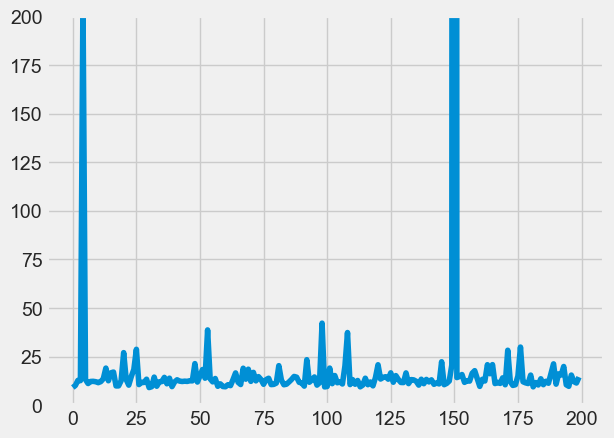

In [67]:
plt.plot(np.arange(len(yi_array[positive_yi_indices])), yi_array[positive_yi_indices])
plt.ylim(0,200)
plt.show()

In [68]:
optimal_det

9.037932964798351

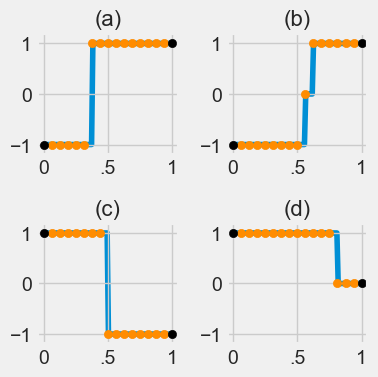

In [69]:
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=np.round(optimal_matrix))

In [70]:
objective_function(optimal_matrix, runs, sum(n_x), J_cb=J_cb, noise=0)

9.658116845417304

In [305]:
# Define autoencoder architecture
input_dim = normalized_designs.shape[1]
latent_dim = 4

autoencoder, encoder, decoder = create_autoencoder(input_dim, latent_dim, dropout_rate=0.01)

# Compile and train the autoencoder with early stopping
autoencoder.compile(optimizer=RMSprop(), loss=tf.keras.losses.Huber())
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = autoencoder.fit(train_data, train_data,
                          epochs=1000,
                          batch_size=32,
                          validation_data=(val_data, val_data),
                          callbacks=[early_stopping])

Epoch 1/1000
25/25 [==============================] - 3s 16ms/step - loss: 0.4591 - val_loss: 0.4356
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.4118 - val_loss: 0.3998
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.3905 - val_loss: 0.3823
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.3709 - val_loss: 0.3548
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.3478 - val_loss: 0.3249
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.3284 - val_loss: 0.3125
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.3147 - val_loss: 0.3040
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.3069 - val_loss: 0.2982
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2991 - val_loss: 0.2870
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2956 - val_loss: 0.282

In [310]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real

# Your provided objective function
def objective_function(X, m, n, J_cb=None, noise=0.1):
    ones = np.ones((m, 1)).reshape(-1,1)
    X = np.array(X).reshape(m, n)
    Z = np.hstack((ones, X @ J_cb))
    try:
        M = np.linalg.inv(Z.T @ Z)
    except np.linalg.LinAlgError:
        return 1e10
    return np.trace(M) + np.random.normal(0, noise)

def objective_function_latent(latent_X, m, n, J_cb, decoder, noise=0.1):
    X_next = decoder.predict(np.array(latent_X).reshape(1, -1))
    X_next = X_next.flatten()
    return objective_function(X_next, m, n, J_cb=J_cb, noise=noise)

# Parameters
n_iterations = 50  # Number of iterations for the optimization process
random_seed = 42  # Random seed for reproducibility

# Adjust the search space to match the latent space dimension
search_space = [Real(-1., 1.) for _ in range(latent_dim)]

gp_result = gp_minimize(
    lambda x: objective_function_latent(x, runs, sum(n_x), J_cb, decoder, noise=0.0),
    search_space,
    n_calls=n_iterations,
    n_random_starts=5,
    random_state=random_seed,
    verbose=True,
    acq_func="LCB",
    initial_point_generator="random",
)

# Get the optimal point in the latent space and objective function value for both methods
optimal_latent_X_gp = gp_result.x
optimal_y_gp = gp_result.fun

# Decode the optimal points in the latent space back into the design matrix space
optimal_X_gp = decoder.predict(np.array(optimal_latent_X_gp).reshape(1, -1))
optimal_X_gp = optimal_X_gp.flatten()

optimal_matrix_gp = np.array(optimal_X_gp).reshape(runs, sum(n_x))
optimal_det_gp = optimal_y_gp

Iteration No: 1 started. Evaluating function at random point.
1/1 [==============================] - 0s 11ms/step
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0594
Function value obtained: 14.1443
Current minimum: 14.1443
Iteration No: 2 started. Evaluating function at random point.
1/1 [==============================] - 0s 41ms/step
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0600
Function value obtained: 26.8852
Current minimum: 14.1443
Iteration No: 3 started. Evaluating function at random point.
1/1 [==============================] - 0s 62ms/step
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0857
Function value obtained: 13.6490
Current minimum: 13.6490
Iteration No: 4 started. Evaluating function at random point.
1/1 [==============================] - 0s 10ms/step
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0314
Function value obtained: 25.6258
Current minimum: 13.6490
Iteration No

In [307]:
import matplotlib.pyplot as plt
import numpy as np

def plot_convergence(result, title):
    plt.style.use('default')
    plt.figure(figsize=(8, 6))
    min_values = np.minimum.accumulate(result.func_vals)  # Calculate the running minimum value
    plt.plot(range(1, len(result.func_vals) + 1), min_values, marker="o")
    plt.xlabel("Number of calls")
    plt.ylabel("Minimum objective function value")
    plt.title(title)
    plt.grid()
    plt.show()

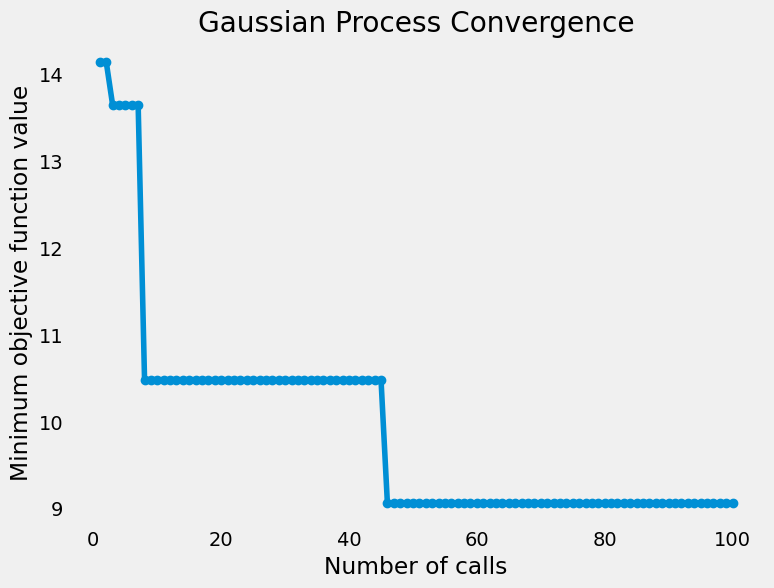

In [308]:
plot_convergence(gp_result, "Gaussian Process Convergence")

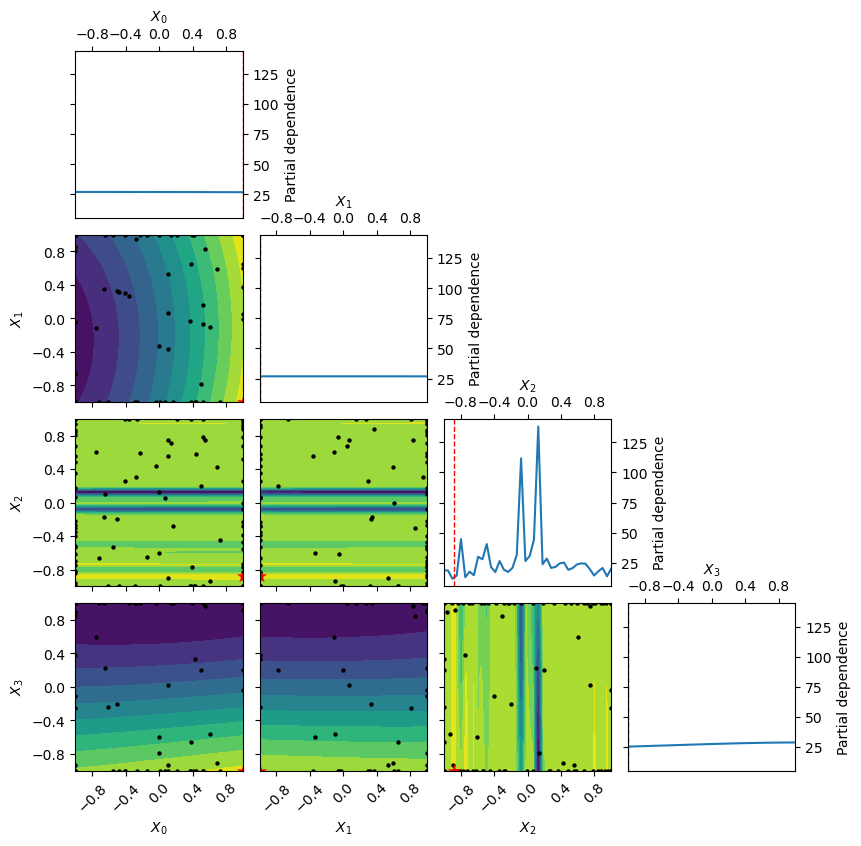

In [311]:
from skopt.plots import plot_objective

plt.style.use('default')

_ = plot_objective(gp_result)
plt.show()

In [294]:
best_design = np.array([
    [1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
    [-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1],
    [-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,-1,-1]
])

In [295]:
objective_function(best_design, runs, sum(n_x), J_cb=J_cb, noise=0)

8.426641910358963

In [296]:
x = scaler.transform(best_design.reshape(1, -1))
latent_representation = encoder.predict(x)
decoded_output = decoder.predict(latent_representation).reshape(-1, sum(n_x))

1/1 [==============================] - 0s 17ms/step


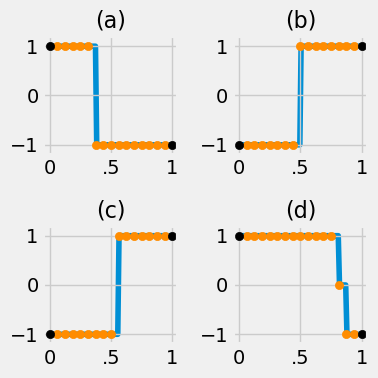

In [297]:
# plot best_design
subplot_results(sub_x=2, sub_y=2, T=np.linspace(0,1,100), results=best_design)